# EDGAR v5 N2O Emissions of Africa for 2015

A quick analysis of the reported N2O emissions for Africa

In [1]:
%matplotlib inline

In [94]:
from pathlib import Path
import math
import xarray as xr
import matplotlib.pyplot as plt

In [45]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            da = da * 3600 * 24 * 365 * 10000
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

In [88]:
def calc_area(lat, pixeldegree):
    area_km2 = (110.45 * pixeldegree) * (111.1944 * pixeldegree) * math.cos(lat * (math.pi / 180.0))
    area_ha  = area_km2 * 100
    return area_ha

In [104]:
def create_area_grid(da, res=0.1):
    da_area = xr.zeros_like(da)
    da_area.attrs = {'long_name': 'area', 'units': 'ha'}
    da_area.name = 'area'
    for lat in da_area.lat.values:
        da_area.loc[{'lat': lat}] = calc_area(lat, res)
    return da_area

In [211]:
def simple_plot(da, title=None, robust=True, cmap='virdrisi'):
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    if title:
        fig.suptitle(title, x=.45, fontsize=18) #horizontalalignment='left')
    da.plot(ax=ax, robust=robust, cmap=cmap)


In [74]:
#patch path to have a ls function
def filter_files(files, include=[], exclude=[]):
    for incl in include:
        files = [f for f in files if incl in f.name]
    for excl in exclude:
        files = [f for f in files if excl not in f.name]
    return sorted(files)

def ls(x, recursive=False, include=[], exclude=[]):
    if not recursive:
        out = list(x.iterdir())
    else:
        out = [o for o in x.glob('**/*')]
    out = filter_files(out, include=include, exclude=exclude)
    return out

Path.ls = ls

In [75]:
data_path = Path('data')
data_path.ls(recursive=True)

[PosixPath('data/v50_N2O_2015'),
 PosixPath('data/v50_N2O_2015/_readme.html'),
 PosixPath('data/v50_N2O_2015/v50_N2O_2015.0.1x0.1.nc'),
 PosixPath('data/v50_N2O_2015_AGS'),
 PosixPath('data/v50_N2O_2015_AGS/_readme.html'),
 PosixPath('data/v50_N2O_2015_AGS/v50_N2O_2015_AGS.0.1x0.1.nc'),
 PosixPath('data/v50_N2O_2015_MNM'),
 PosixPath('data/v50_N2O_2015_MNM/_readme.html'),
 PosixPath('data/v50_N2O_2015_MNM/v50_N2O_2015_MNM.0.1x0.1.nc'),
 PosixPath('data/v50_N2O_2015_N2O'),
 PosixPath('data/v50_N2O_2015_N2O/_readme.html'),
 PosixPath('data/v50_N2O_2015_N2O/v50_N2O_2015_N2O.0.1x0.1.nc')]

In [90]:
n2o = xr.open_dataset(data_path / 'v50_N2O_2015' / 'v50_N2O_2015.0.1x0.1.nc')['emi_n2o']
n2o = preprocess_edgar_nc(n2o)

In [107]:
# create an area grid for calculation of totals
area = create_area_grid(n2o)
area.to_netcdf('area.nc')

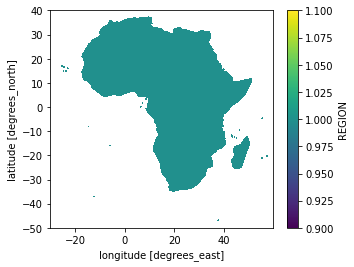

In [214]:
import numpy as np
# africa mask
admin = xr.open_dataset(data_path / 'tmworld_01deg.nc').sel(lat=slice(-50,40), lon=slice(-30, 60))
africa = admin.REGION.where(admin.REGION == 2).notnull()
africa = africa.where(africa == 1)
africa.plot(figsize=(5,4));

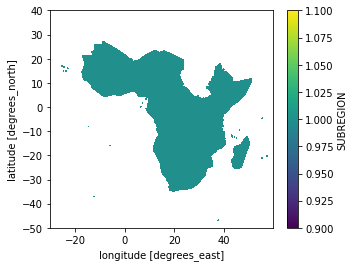

In [215]:
# second mask
subafrica = (admin.SUBREGION.where(admin.REGION == 2)
                            .where(admin.SUBREGION != 15)
                            .notnull())
subafrica = subafrica.where(subafrica == 1)
subafrica.plot(figsize=(5,4));

## Total N2O emissions

### Africa

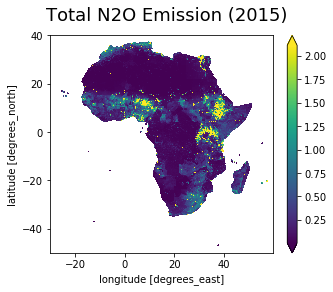

In [171]:
simple_plot(n2o*africa, title="Total N2O Emission (2015)")

In [172]:
# Total emissions
total = float((n2o*africa*area).sum()) / 1_000_000
print(f"Total annual N2O emission: {total:.1f} Gg yr-1")

Total annual N2O emission: 975.1 Gg yr-1


### Sub-Sahara

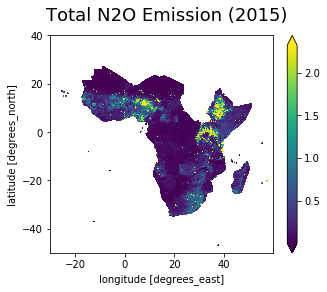

In [173]:
simple_plot(n2o*subafrica, title="Total N2O Emission (2015)")

In [168]:
# Total emissions
total = float((n2o*subafrica*area).sum()) / 1_000_000
print(f"Total annual N2O emission: {total:.1f} Gg yr-1")

Total annual N2O emission: 770.7 Gg yr-1


## Manure management

### Africa

In [174]:
manure = xr.open_dataset(data_path / 'v50_N2O_2015_MNM' / 'v50_N2O_2015_MNM.0.1x0.1.nc')['emi_n2o']
manure = preprocess_edgar_nc(manure)

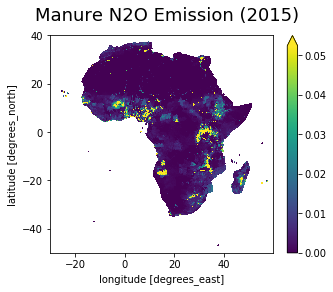

In [176]:
simple_plot(manure*africa, title="Manure N2O Emission (2015)")

In [178]:
# Manure emissions
total = float((manure*africa*area).sum()) / 1_000_000
print(f"Annual N2O emission from manure: {total:.1f} Gg yr-1")

Annual N2O emission from manure: 17.0 Gg yr-1


### Sub-Sahara

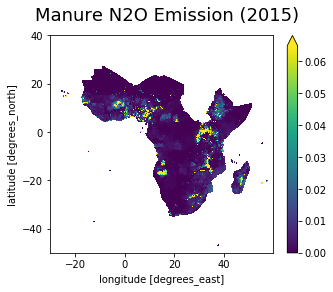

In [177]:
simple_plot(manure*subafrica, title="Manure N2O Emission (2015)")

In [179]:
# Manure emissions
total = float((manure*subafrica*area).sum()) / 1_000_000
print(f"Annual N2O emission from manure: {total:.1f} Gg yr-1")

Annual N2O emission from manure: 15.3 Gg yr-1


## Agricultural soils

### Africa

In [183]:
soil = xr.open_dataset(data_path / 'v50_N2O_2015_AGS' / 'v50_N2O_2015_AGS.0.1x0.1.nc')['emi_n2o']
soil = preprocess_edgar_nc(soil)

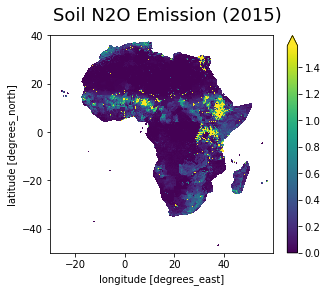

In [185]:
simple_plot(soil*africa, title="Soil N2O Emission (2015)")

In [187]:
# Soil emissions
total = float((soil*africa*area).sum()) / 1_000_000
print(f"Annual N2O emission from soil: {total:.1f} Gg yr-1")

Annual N2O emission from soil: 683.1 Gg yr-1


### Sub-Sahara

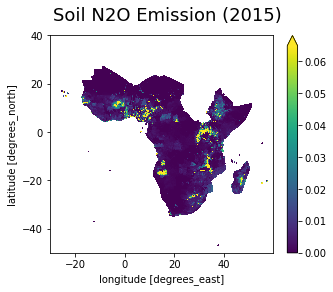

In [186]:
simple_plot(manure*subafrica, title="Soil N2O Emission (2015)")

In [189]:
# Soil emissions
total = float((soil*subafrica*area).sum()) / 1_000_000
print(f"Annual N2O emission from soil: {total:.1f} Gg yr-1")

Annual N2O emission from soil: 543.9 Gg yr-1


## Indirect N2O from agriculture

### Africa

In [190]:
indirect = xr.open_dataset(data_path / 'v50_N2O_2015_N2O' / 'v50_N2O_2015_N2O.0.1x0.1.nc')['emi_n2o']
indirect = preprocess_edgar_nc(indirect)

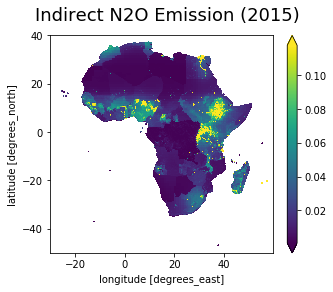

In [192]:
simple_plot(indirect*africa, title="Indirect N2O Emission (2015)")

In [194]:
# Indirect emissions
total = float((indirect*africa*area).sum()) / 1_000_000
print(f"Indirect N2O emission from agriculture: {total:.1f} Gg yr-1")

Indirect N2O emission from agriculture: 69.6 Gg yr-1


### Sub-Sahara

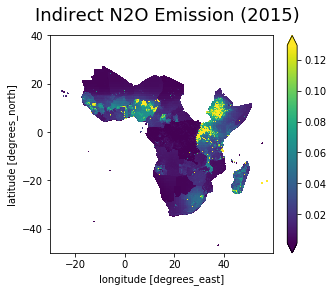

In [193]:
simple_plot(indirect*subafrica, title="Indirect N2O Emission (2015)")

In [195]:
# Indirect emissions
total = float((indirect*subafrica*area).sum()) / 1_000_000
print(f"Indirect N2O emission from agriculture: {total:.1f} Gg yr-1")

Indirect N2O emission from agriculture: 55.7 Gg yr-1


## Total N2O from Agriculture

### Africa

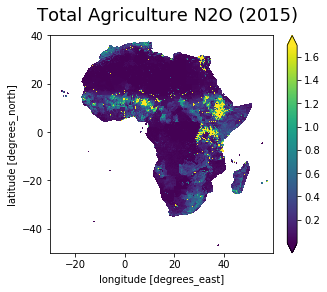

In [201]:
simple_plot((manure+soil+indirect)*africa, title="Total Agriculture N2O (2015)")

In [200]:
# Indirect emissions
total = float(((manure+soil+indirect)*africa*area).sum()) / 1_000_000
print(f"Total N2O emission from agriculture: {total:.1f} Gg yr-1")

Total N2O emission from agriculture: 769.6 Gg yr-1


### Sub-Sahara

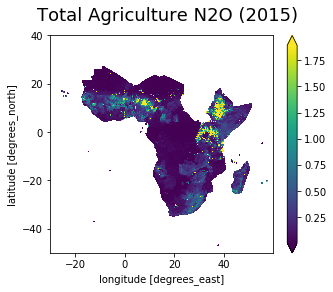

In [202]:
simple_plot((manure+soil+indirect)*subafrica, title="Total Agriculture N2O (2015)")

In [203]:
# Indirect emissions
total = float(((manure+soil+indirect)*subafrica*area).sum()) / 1_000_000
print(f"Total N2O emission from agriculture: {total:.1f} Gg yr-1")

Total N2O emission from agriculture: 614.9 Gg yr-1


## Ratio of total agriculture N2O to total N2O

### Africa

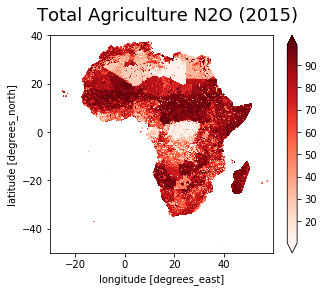

In [212]:
simple_plot(((manure+soil+indirect)/n2o)*africa * 100, title="Total Agriculture N2O (2015)", cmap='Reds')

### Sub-Sahara

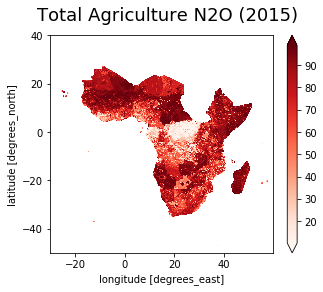

In [213]:
simple_plot(((manure+soil+indirect)/n2o)*subafrica * 100, title="Total Agriculture N2O (2015)", cmap='Reds')